# Etude de la régularisation par le Laplacien
*Guillaume Fidanza*

Version testée sur la configuration suivante:

Version s'apprêtant à être éxécutée sur la configuration suivante:

In [1]:
from __future__ import print_function
import sys
jupyter_version = !jupyter --version 
print("The version of the notebook server is",jupyter_version[0],"and is running on:\n")
print("Python",sys.version)

The version of the notebook server is 4.1.0 and is running on:

Python 2.7.11 |Anaconda 4.0.0 (64-bit)| (default, Dec  6 2015, 18:08:32) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


# Sommaire

- [Introduction](#Introduction)
 - [Création du graphe](#Création-du-graphe)
- [Résolution avec le Laplacien](#Régularisation-avec-le-Laplacien)
 - [Méthode 1: régularisation L2](#Méthode-1:-régularisation-L2)
   - [Résolution analytique](#Résolution-analytique)
   - [Implémentation](#Implémentation)
   - [Interprétation](#Interprétation)
 - [Méthode 2: régularisation L1](#Méthode-2:-régularisation-L1)
   - [Définition du problème dual](#Définition-du-problème-dual)
   - [Résolution avec le gradient projeté](#Résolution-avec-le-gradient-projeté)
   - [Paramètrage du pas de gradient](#Paramètrage-du-pas-de-gradient)
     - [Majorant via définition de Lipschitz (norme Frobenius)]
     - [Majorant du gradient projeté sur sphère unité (norme vectorielle)]
     - [Majorant du gradient projeté adaptatif (norme vectorielle à chaque pas)]

[^Revenir au sommaire](#Sommaire)

# Introduction

Nous allons essayer de débruiter une image. 

Caractéristiques de l'image:
- Dimensions 256x256 = m x m pixels
- En niveaux de gris 8 bits. Chaque pixel contient l'intensité comprise de $0$(noir) à $2^8 - 1 = 255$(blanc)

Dans le but d'utiliser la structure de l'image, On définit un graphe associé:

**Version mathématique**

Un pixel est représenté par une position en deux dimensions (ligne, colonne)

$G(V,E)$ avec $V = \left\{ (i,j) \in [\![1, m ]\!]^2 \right\}$

$E_{\text{Voisins droite}} =\left\{ \left((i,j), (i+1,j)\right), \forall i \leq m-1, j\leq m \right\}$

$E_{\text{Voisins bas}}  =\left\{ \left((i,j), (i,j+1)\right), \forall i \leq m, j\leq m-1 \right\}$

$E = E_{\text{Voisins droite}} \cup E_{\text{Voisins bas}} \subseteq V \times V$

**Version informatique**

Un pixel est représenté par une position en une dimension (abscisse)

$G(V,E)$ avec $V = \{0,1,\dots,m^2-1\}$

$E_{\text{Voisins droite}} = \left\{ \left(im+j, (i+1)m+j\right), (i,j) \in \mathbb{N}^2, i < m-1, j < m \right\} $

$E_{\text{Voisins bas}} = \left\{ \left(im+j, im+j+1\right), (i,j) \in \mathbb{N}^2, i < m, j < m-1 \right\} $

$E = E_{\text{Voisins droite}} \cup E_{\text{Voisins bas}} \subseteq V \times V$

Dans cette section, on va considérer un signal sur une grille 2D régulière, c’est-à-dire une image
numérique. L’image originale cam.png avec laquelle on travaillera est en niveau de gris. Le graphe G que
l’on considère est un graphe régulier : chaque pixel est lié à son voisin de droite et à son voisin du dessous.
On observe un signal sur le graphe, qui est la valeur des pixels. On va tenter de régulariser ce signal par
deux types de méthodes.

## Création du graphe
Nous allons créer le graphe associé à une image qui a 256 × 256 pixels.

TODO Insérer calcul théorique du nombre d'arêtes: $2m(m-1)$

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import timeit
from scipy.sparse.linalg import lsqr

%matplotlib inline
np.random.seed(1)
plt.close('all')

print("Graph construction")
m = 256 #dimension de l'image (nombre de pixels)
G = nx.empty_graph(m * m)
#Construction des arêtes
voisin_bas_edges = [(i*m+j, (i+1)*m+j) for i in xrange(m-1) for j in xrange(m)]
voisin_droite_edges = [(i*m+j, i*m+j+1) for i in xrange(m) for j in xrange(m-1)]
#Chargement des arêtes dans le graphe
G.add_edges_from(voisin_bas_edges)
G.add_edges_from(voisin_droite_edges)

print("Chargement des",G.number_of_edges(),"arêtes, le compte est bon?",G.number_of_edges() == 2*m*(m-1))

B = nx.incidence_matrix(G, oriented=True)
BT = B.T
nb_nodes = B.shape[0]
nb_edges = B.shape[1]

Graph construction
Chargement des 130560 arêtes, le compte est bon? True


**Qu'allons-nous faire ?**

Nous allons charger l'image en niveau de gris compris entre 0 et 1, et renormaliser l'intensité des pixels entre 0 et 255 (en float64).

**Pourquoi renormaliser ?**

Dans la suite, nous risquons de faire appel à des solveurs qui assurent une certaine précision. Il est préférable de travailler en comptant le moins sur les virgules flottantes. 

La normalisation n'a pas d'influence sur l'affichage en niveau de gris avec imshow(), en revanche cette fonction impose d'avoir des valeurs normalisées entre 0 et 1 pour d'autres formats (ex: RGB). C'est sûrement pour cette raison que Matplotlib normalise entre 0 et 1 par défaut.

**Que fait Matplotlib exactement ?**

Matplotlib lit l'image PNG, normalise ses valeurs entre 0 et 1 (en float64) et les renvoie en float32 par défaut ([+ d'infos](https://github.com/matplotlib/matplotlib/blob/196f3446a3d5178c58144cee796fa8e8aa8d2917/src/_png.cpp#L601))

In [51]:
#Chargement de l'image et normalisation des niveaux de gris entre 0 et 255 en float64
y_true = 255 * np.reshape(plt.imread('cam.png').astype(np.double), nb_nodes)
y_true32 = 255 * np.reshape(plt.imread('cam.png'), nb_nodes)
#On ajoute un bruit gaussien
y =  y_true + 40 * np.random.randn(nb_nodes)

In [55]:
255*max(y_true - y_true32)

0.0019302964210510254

In [73]:
plt.imshow?

In [74]:
plt.imshow??

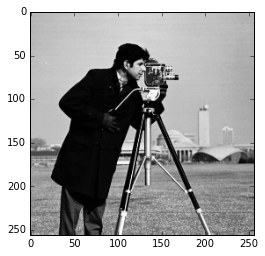

In [67]:
#sp.misc.imread?
_ = plt.imshow(plt.imread('cam.png'), cmap='Greys_r')

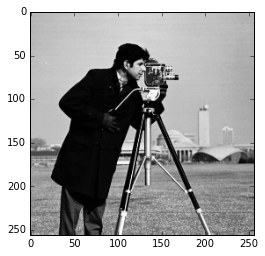

In [62]:
_ = plt.imshow(np.reshape(y_true32-1000000, [256, 256]), cmap='Greys_r')

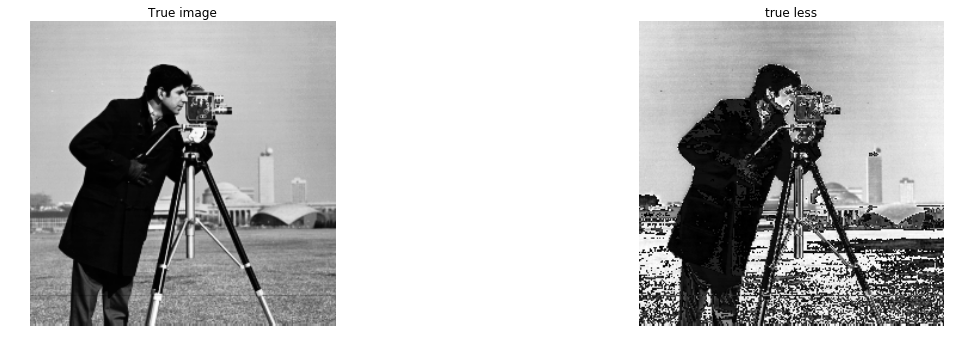

In [64]:
#plt.imshow(np.reshape(y_true, [256, 256]), cmap='Greys_r')

display_images([('True image',y_true), ('true less', y_true - 255 * np.reshape(plt.imread('cam.png'), nb_nodes))], n_images_par_ligne = 2)

In [32]:
plt._imread??

In [39]:
from matplotlib._png import read_png
read_png??

In [40]:
plt.imread?

In [8]:
m**2

65536

[^Revenir au sommaire](#Sommaire)

# Régularisation avec le Laplacien

On note $y \in \mathbb{R}^n$ (avec $n = 256^2 = 65536$) le signal correspondant à une version bruitée de l’image.

On note $B \in \mathbb{R}^{n \times p}$ (avec $p = 131072$) la matrice d’incidence du graphe. 

## Méthode 1: régularisation L2

La première méthode consiste à régulariser le signal y sur le graphe en utilisant la procédure
suivante :

$\DeclareMathOperator*{\argmin}{\arg\!\min}$

$ \hat{\beta} = \argmin_{\beta \in \mathbb{R}^n} \| y - \beta\|_2^2 + \lambda\|B^T \beta\|_2^2$


Pour le calcul du Laplacien L dans sa forme quadratique illustrant la contrainte de lissage($\lambda\|B^T \beta\|_2^2$, on utilise la matrice d'incidence B.
\begin{align}
\lambda\|B^T \beta\|_2^2 & = \lambda (B^T\beta)^T(B^T\beta) \\
 & = \lambda \beta^TBB^T\beta\\
 & = \lambda \beta^TL\beta\ \;(\text{En prenant le Laplacien } L = BB^T)
\end{align}

- Le premier terme décrit l'**attache aux données**. Même si l'image $y$ est bruitée, elle contient la majeure partie des informations pertinentes. On cherche donc à minimiser la différence entre l'image que nous construisons $\beta$ et y.
- Le second terme est la **contrainte de lissage**. Elle signifie que si deux pixels(noeuds) sont proches dans l'image $y$ (le graphe $G$), l'image que nous construisons $\beta$ (la fonction de graphe)

Une fonction de graphe donne une valeur à chaque noeud. 
Dans notre cas, on peut voir notre image $\beta$ comme une fonction du graphe de notre image donnant un niveau de gris à chaque pixel.

$\beta : V \rightarrow [0, 255]$

### Résolution analytique

Proposer une résolution faisant intervenir une résolution de système impliquant la matrice Laplacienne du graphe. Attention, 

En annulant le gradient de la fonction objectif du problème d'optimisation, on obtient:

$ \hat{\beta} = (I_{n,n} + \lambda BB^T)^{-1}y$

[^Revenir au sommaire](#Sommaire)

### Implémentation
inverser une matrice de taille 65536 × 65536 peut être problématique. On utilisera des matrices parcimonieuses (sparses).

In [43]:
from scipy import sparse

print("Laplacian regularization")
lambda_reg = 15  # regularization parameter

def laplacian_reg(lambda_reg, y, B, iter_lim=10000):
    """
    Effectue une régularisation Laplacienne 
    """
    A = sparse.eye(len(y)) + lambda_reg * B*B.T
    return sparse.linalg.lsqr(A,y, iter_lim=iter_lim)[0] #On résout A*Beta = y

%time Beta_Laplacian = laplacian_reg(lambda_reg, y, B)

Laplacian regularization
CPU times: user 4.09 s, sys: 86.9 ms, total: 4.18 s
Wall time: 1.39 s


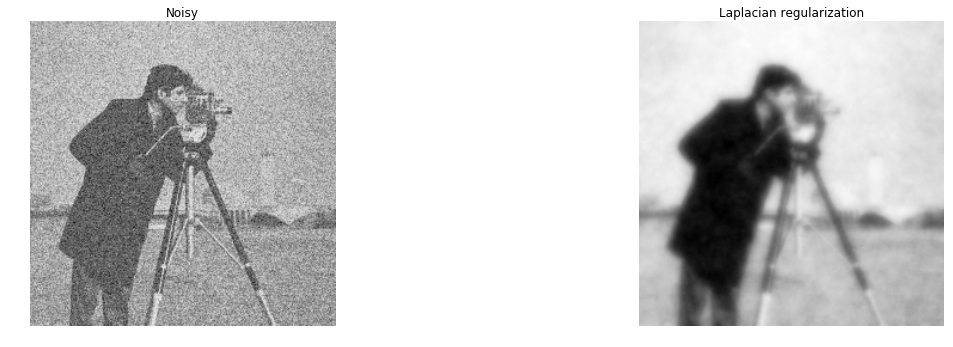

In [44]:
images = [('Noisy',y), ('Laplacian regularization',Beta_Laplacian)]

#Affichage des images sur plusieurs lignes

def display_images(images, n_images_par_ligne = 3):
    """
    Affiche des images dans un quadrillage lignes-colonnes
    """
    plt.figure(figsize=(20,12*(len(images)//n_images_par_ligne)))
    for i,(titre,image) in enumerate(images):
        #print((len(images)//n_images_par_ligne), n_images_par_ligne, i+1)
        plt.subplot((len(images)//n_images_par_ligne)+1, n_images_par_ligne, i+1)
        plt.imshow(np.reshape(image, [256, 256]), cmap='Greys_r')
        plt.axis('off')
        plt.title(titre)
    #plt.tight_layout()

display_images(images, n_images_par_ligne = 2)

[^Revenir au sommaire](#Sommaire)

### Interprétation
Variation du paramètre λ

In [9]:
def gen_power_range(lower,upper):
    """
    Génère une suite de valeurs croissantes en puissance.
    Ex: [1.1e-4, 3.1e-4, ...., 1e+2, 3e+2] avec lower=-4 et upper=2
    """
    powers = 10**np.arange(lower,upper, dtype="float128") #[ 1e-08  1e-07...
    power_range = np.repeat(powers[:,np.newaxis],2, axis=1)*[1, 3] 
    return power_range.flatten()

In [173]:
lambda_range = gen_power_range(-4,5)
%time images = [('lambda='+str(lambda_reg), laplacian_reg(lambda_reg, y, B)) for lambda_reg in lambda_range]
images.insert(0,('Noisy',y))

CPU times: user 5min 26s, sys: 6.19 s, total: 5min 32s
Wall time: 1min 23s


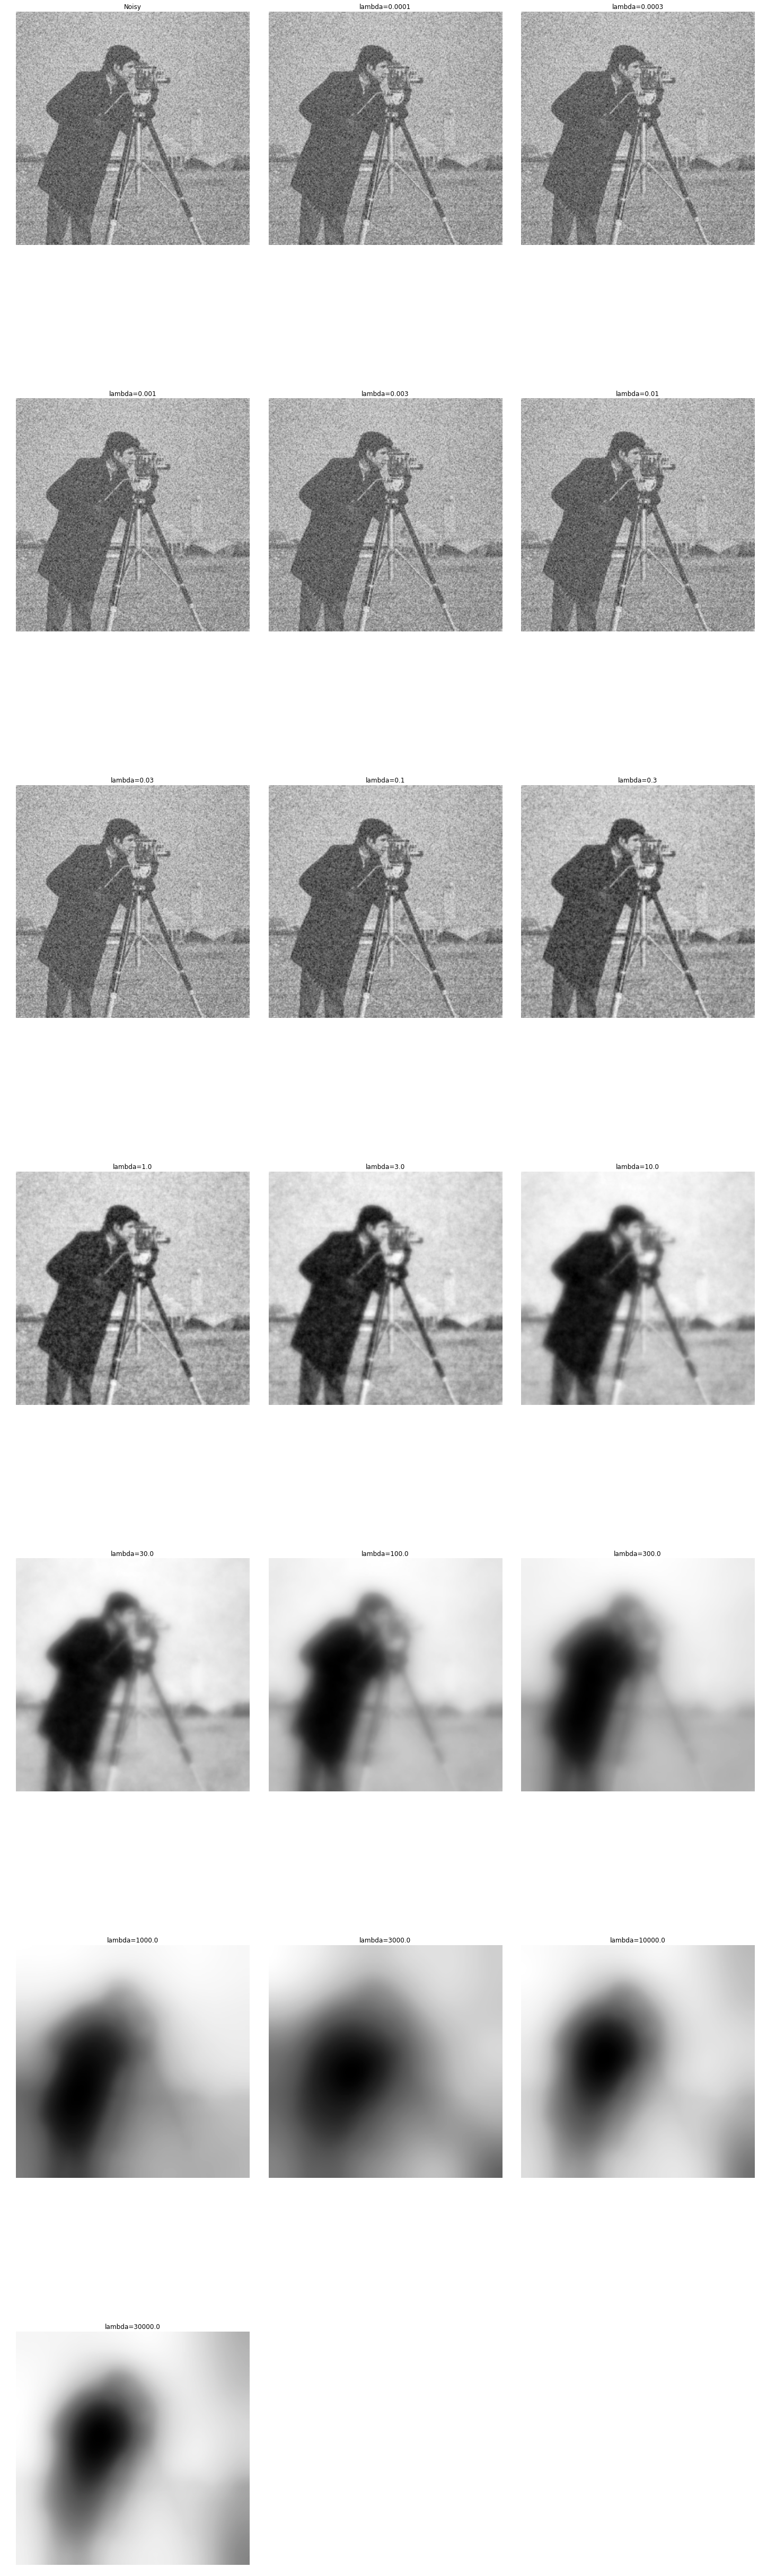

In [174]:
display_images(images, n_images_par_ligne = 3)

On observe que pour lorsque le paramètre de régularisation est faible, on retrouve l'image bruitée. Cela concorde avec le comportement asymptotiquement de la solution:

$ \hat{\beta} = (I_{n,n} + \lambda BB^T)^{-1}y \xrightarrow{\lambda \to 0} y$

Avec une pénalité L2 très forte, On s'éloigne beaucoup de l'image initiale tout en maintenant une certaine structure entre les pixels grâce à la matrice d'incidence.

[^Revenir au sommaire](#Sommaire)

## Méthode 2: régularisation L1


La seconde méthode consiste à régulariser le signal sur le graphe en utilisant la procédure suivante :

$ \hat{\beta} = \argmin_{\beta \in \mathbb{R}^n} \| y - \beta\|_2^2 + \lambda\|B^T \beta\|_1$

### Définition du problème dual

On pourra résoudre le problème dual associé

$ \hat{\theta} = \argmin_{\theta \in \mathbb{R}^p, ||\theta||_{\infty} \leq 1}|| y - \lambda B \theta ||^2_2$

en utilisant une méthode de type gradient projeté (un cas particulier des algorithmes de type
implicite-explicite, en anglais Forward-Backward ), et en utilisant la relation primal-duale (admise) :

$B\hat{\theta}= (y − \hat{\beta})/\lambda$
pour retrouver la valeur du problème primale dans (2). 
- TODO détailler implémententation de cet algorithme plus bas, dont critère d'arrêt: saut de dualité < seuil.

[^Revenir au sommaire](#Sommaire)

### Résolution avec le gradient projeté

On commence par cal

Le gradient projeté se déroule en deux parties:
- Une étape de gradient: $\theta_{t+1} = \theta_t - \alpha_\lambda * \nabla_{\theta}F(\theta_t)$

\begin{align}
F(\theta) & =  \frac{1}{2}|| y - \lambda B \theta ||^2_2 \\
&= (y - \lambda B \theta)^T(y - \lambda B \theta)\\
\nabla_{\theta}F(\theta) & = - \lambda B^T(y - \lambda B \theta)\\
 & = \lambda^2 B^T B\theta - \lambda B^T y \\
\nabla_{\theta}^2F(\theta) & = \lambda^2 B^T B
\end{align}
La fonction objectif $F(\theta)$ étant polynomiale, elle est L-Lipschitzienne.
Sa hessienne $\nabla_{\theta}^2F(\theta)$ est positive semi-définie (car c'est une matrice de Gram) et constante. Ce qui veut dire que F n'a pas de point d'inflexion et que sa constante de Lipschitz L peut être arbitrairement grande.

Cela pose problème puisque pour assurer la convergence raisonnablement rapide de l'algorithme du gradient, il faut choisir un pas $\frac{1}{L} \leq \alpha \leq \frac{2}{L} $ 

- Une projection sur la sphère unité (contrainte $||\theta||_{\infty} \leq 1$ )

### Paramètrage du pas de gradient

On va tester plusieurs façon de calculer L:
- Majorant via définition de Lipschitz (norme Frobenius)
- Majorant du gradient projeté sur sphère unité (norme vectorielle)
- Majorant du gradient projeté adaptatif (norme vectorielle à chaque pas)

Pour cela on va:
- afficher le saut de dualité en fonction du nombre d'itérations
- afficher le nombre d'itérations max pour converger(seuil à fixer)+temps en fonction de lambda

#### Majorant via définition de Lipschitz (norme Frobenius)

//A faire

#### Majorant du gradient projeté sur sphère unité (norme vectorielle)

L est aussi un majorant du gradient de la fonction objectif ($\nabla_{\theta}F(\theta)$). On peut utiliser la contrainte de maintien de $\theta$ dans la sphère unité pour choisir une valeur de L. L'existence de L étant montrée, on peut choisir arbitrairement une norme pour déterminer sa valeur. Nous utiliserons la norme de Frobenius.

\begin{align} \forall \theta \in \mathbb{R}^p \text{tel que } ||\theta||_{\infty} \leq 1,  \|\nabla_{\theta}F(\theta)\|_F &\leq \|\nabla_{\theta}F(1_p)\|_F \\
\Leftrightarrow \|\nabla_{\theta}F(\theta)\|_F &\leq \| \lambda^2 B^T B 1_p- \lambda B^T y\|_F
\end{align}

On choisit alors de définir le pas $\alpha$ avec sa borne supérieure pour accélérer la convergence ($\frac{2}{L}$):

\begin{align}
L &= \| \lambda^2 B^T B 1_p- \lambda B^T y\|_F \\
\alpha_\lambda & = \frac{2}{L} \\
\alpha_\lambda & = \frac{2}{\| \lambda^2 B^T B 1_p- \lambda B^T y\|_F \\}
\end{align}

#### Majorant du gradient projeté adaptatif (norme vectorielle à chaque pas)

// A faire

[^Revenir au sommaire](#Sommaire)

In [13]:
def tv_reg(y, B, lambda_reg, L, tmax=10000, eps=10**(-8)):
    """ Effectue une régularisation par gradient projeté afin de résoudre le problème dual  """
    nb_nodes = B.shape[0]
    nb_edges = B.shape[1]

    #Constante de Lipschitz
    #L = np.linalg.norm((lambda_reg**2) *(B.T.dot(B.dot(np.ones(nb_edges)))) - lambda_reg * B.T.dot(y))
    #print("Lipschitz (Fro/Me) = ",L)
    #Init
    Beta = np.mean(y) * np.ones(nb_nodes)
    Theta = np.zeros(nb_edges)
    
    Beta, _ = ista(y, B, B.T, L, lambda_reg, Beta, Theta, tmax=tmax, eps=eps)
    return Beta

def ista(y, D, DT, L, lbd, Beta, Theta, active=True,
         tmax=1000, eps=10 ** (-14)):
    """ Effectue une régularisation par gradient projeté afin de résoudre le problème dual 
    
    Parameters
    ------------
    L_type: Type de majoration pour le calcul de la constante de Lipschitz, string, valeurs possibles:
        - 'definition' :  calcul par majoration en revenant à la définition de L
        - 'proj_sphere' : calcul par majoration du gradient en projetant sur la sphère unité
        - 'proj_adapt' :  calcul par majoration du gradient en projetant à chaque étape (dépend de Beta(t))
    """
    thr = eps * np.linalg.norm(y) ** 2
    nonstop = True
    t = 1

    #gradient = a * Theta + b
    alpha = 2. / L #Pas du gradient
    B_gram = D.T.dot(D)
    print("alpha=",alpha)
    a = lbd**2 *B_gram
    b = -lbd * B.T.dot(y)
    
    while nonstop:
        Beta = y - lbd * D.dot(Theta)
        gap = np.maximum(dual_gap(y, Beta, Theta, D, DT, lbd), 0)
        gradient = a.dot(Theta) + b
        Theta = Theta - alpha * gradient
        Theta = projinf(Theta)
        nonstop = (gap > thr) & (t < tmax)
        t += 1
        #print(str(t) + " " + str(gap))

    return Beta, Theta


def projinf(z):
    """  projection sur la sphère unité """
    #print(z)
    out_sphere_unity = np.abs(z) > 1
    z[out_sphere_unity] = np.sign(z[out_sphere_unity])
    return  z

def primal(y, Beta, DT, lbd):
    return 1. / 2. * np.linalg.norm(y - Beta) ** 2 + \
        lbd * np.linalg.norm(DT.dot(Beta), 1)


def dual(y, D, Theta, lbd):
    return 1. / 2. * np.linalg.norm(y) ** 2 - \
        lbd ** 2 / 2. * np.linalg.norm(D.dot(Theta) - y / lbd) ** 2


def dual_gap(y, Beta, Theta, D, DT, lbd):
    return primal(y, Beta, DT, lbd) - dual(y, D, Theta, lbd)

In [14]:
nb_edges = B.shape[1]

In [38]:
####Test des normes Fro
lambda_reg = 400  # regularization parameter

%time L = np.linalg.norm((lambda_reg**2) *(B.T.dot(B.dot(np.ones(nb_edges)))) - lambda_reg * B.T.dot(y))
print("Lipschitz (Fro/Me) = ",L)

%time L_autre = sp.sparse.linalg.norm((lambda_reg**2) *(B.T.dot(B)), ord='fro')
print("Lipschitz (Fro/Autre) = ",L_autre)

#%time L_autre_eig = sp.sparse.linalg.eigs((lambda_reg**2) *(B.T.dot(B)), k=1)[0][0]
#print("Lipschitz (Eig/Autre) = ",L_autre_eig)


#%time Beta = tv_reg(y, B, lambda_reg, L)

CPU times: user 5.18 ms, sys: 0 ns, total: 5.18 ms
Wall time: 3.69 ms
Lipschitz (Fro/Me) =  10110192.7151
(130560, 130560)
CPU times: user 82.6 ms, sys: 3.86 ms, total: 86.5 ms
Wall time: 21.8 ms
Lipschitz (Fro/Autre) =  182605918.853
CPU times: user 21min 35s, sys: 19.6 s, total: 21min 55s
Wall time: 5min 29s
Lipschitz (Eig/Autre) =  (1279951.80918+0j)


In [52]:
####Test des normes Fro
lambda_reg = 40  # regularization parameter

%time L = np.linalg.norm((lambda_reg**2) *(B.T.dot(B.dot(np.ones(nb_edges)))) - lambda_reg * B.T.dot(y))
print("Lipschitz (Fro/Me) = ",L)

%time L_autre = sp.sparse.linalg.norm((lambda_reg**2) *(B.T.dot(B)), ord='fro')
print("Lipschitz (Fro/Autre) = ",L_autre)

print(L_autre/L)

#%time L_autre_eig = sp.sparse.linalg.eigs((lambda_reg**2) *(B.T.dot(B)), k=1)[0][0]
#print("Lipschitz (Eig/Autre) = ",L_autre_eig)


#%time Beta = tv_reg(y, B, lambda_reg, L)

CPU times: user 4.09 ms, sys: 62 µs, total: 4.15 ms
Wall time: 3.29 ms
Lipschitz (Fro/Me) =  872485.312388
CPU times: user 125 ms, sys: 7.94 ms, total: 133 ms
Wall time: 33.2 ms
Lipschitz (Fro/Autre) =  1826059.18853
2.09293974649


In [1]:
from scipy.linalg import eigvals

#%time np.linalg.norm((lambda_reg**2) *(B.T.dot(B.dot(np.ones(nb_edges)))) - lambda_reg * B.T.dot(y))
#%time sp.sparse.linalg.eigs((lambda_reg**2) *(B.T.dot(B.dot(np.ones(nb_edges)))) - lambda_reg * B.T.dot(y), k=1)

In [ ]:
####Test des normes spectrales
from scipy.linalg import eigvals
L =

L = np.linalg.norm((lambda_reg**2) *(B.T.dot(B.dot(np.ones(nb_edges)))) - lambda_reg * B.T.dot(y))
print("Lipschitz (Fro/Me) = ",L)

lambda_reg = 400  # regularization parameter
%time Beta = tv_reg(y, B, lambda_reg)

In [200]:
print("\nForward Backward in the dual space")
lambda_reg = 400  # regularization parameter

%time Beta = tv_reg(y, B, lambda_reg)


Forward Backward in the dual space
alpha= 1.97820165883e-07
CPU times: user 3min 11s, sys: 3.77 s, total: 3min 15s
Wall time: 48.9 s


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.9 µs


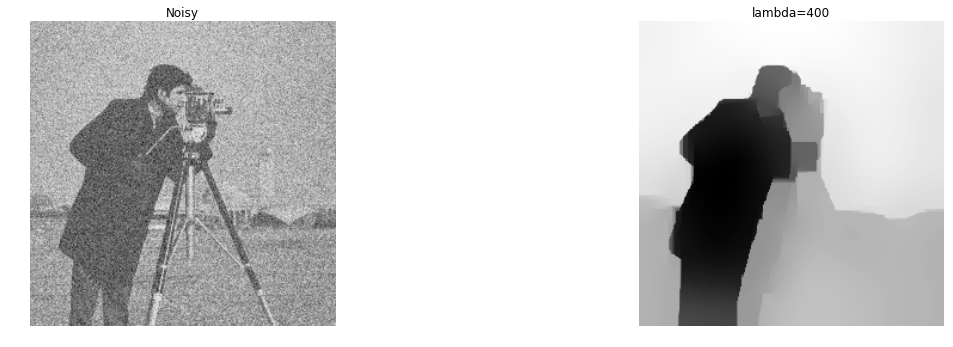

In [201]:
lambda_range = [400]
%time images_TV = [('lambda='+str(lambda_reg), Beta) for lambda_reg in lambda_range]
images_TV.insert(0,('Noisy',y))

display_images(images_TV, n_images_par_ligne=2)

### Variation du paramètre λ

In [202]:
lambda_range = [1, 10, 30, 100, 1000]

%time images_TV = [('lambda='+str(lambda_reg), tv_reg(y, B, lambda_reg)) for lambda_reg in lambda_range]
images_TV.insert(0,('Noisy',y))

alpha= 9.18595047006e-05
alpha= 9.18475548761e-06
alpha= 3.05878657508e-06
alpha= 9.08605499851e-07
alpha= 5.16315970074e-08
CPU times: user 17min 49s, sys: 21.6 s, total: 18min 10s
Wall time: 4min 32s


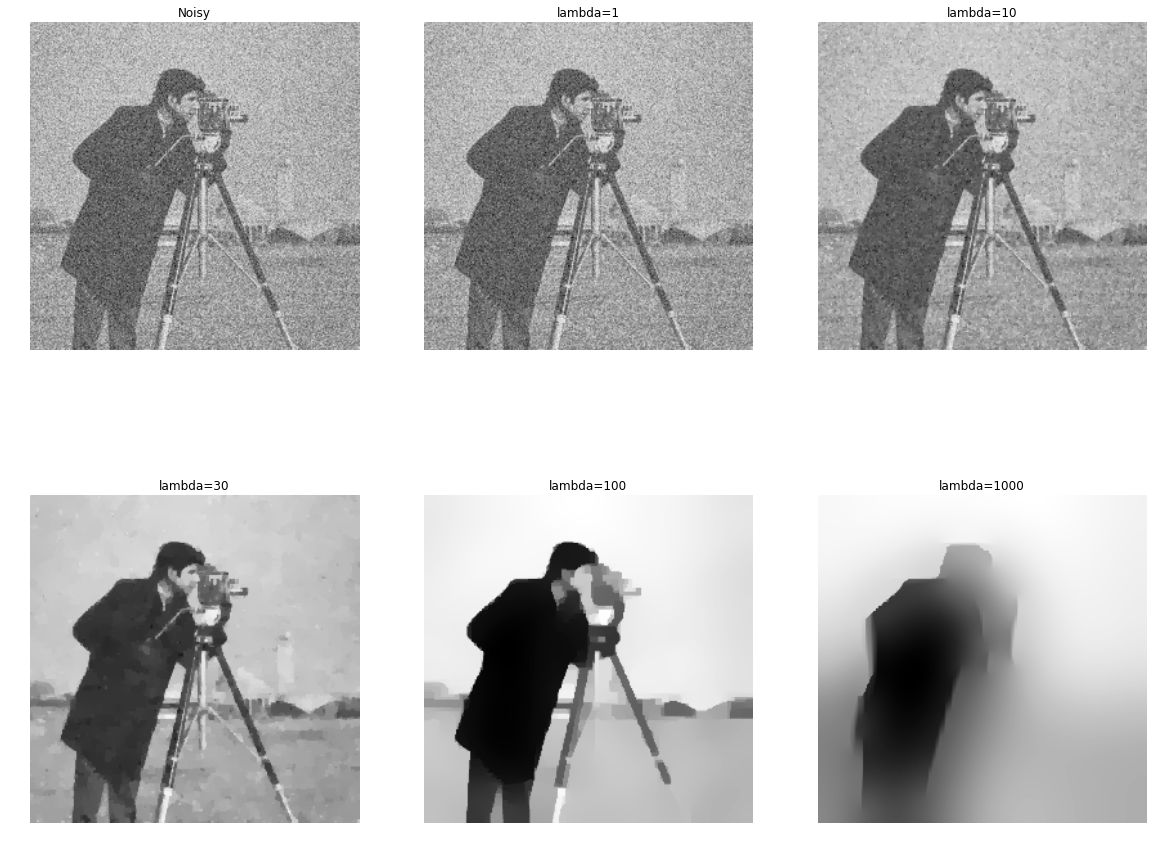

In [203]:
display_images(images_TV, n_images_par_ligne=3)

Lorsque le paramètre de régularisation est faible, on retrouve l'image initiale bruitée.

En revanche, lorsque la pénalité L1 est forte, on cherche à reconstruire une image (signal) parcimonieuse, c'est-à-dire avec peu de couleurs ou de mélanges complexes de couleurs (ex: éclairage, halo...)

[^Revenir au sommaire](#Sommaire)